## Sentiment Analysis and Topic Modeling for Product Reviews

<b>Project Overview:</b> This project has two goals:
1. to analyze text based product reviews to ascertain if they are positive or negative (i.e., sentiment analysis utilizing text classification); and
2. to extract any common themes (i.e., topic modeling) from the negative reviews which may be useful for future product development

<b>Dataset and Technology:</b> The dataset is an extract of ~400K reviews for various electronics sold on Amazon. The project is executed in Python, using predominantly the nltk/spacy, sklearn and gensim libraries.

* [Goal 1 - Sentiment Analysis](#sent)
  * [Gridsearch based Vectorization](#gs_vec)
  * [Multinomial Naive Baiyes](#mnb)
  * [Logistic Regression](#lr)
  * [Random Forest Classifier](#rf)
  * [TextBlob](#tb)
  * [VADER](#vader)
  * [Summary of Results](#summ)
#####
* [Goal 2 - Topic Modeling](#top)

###
#### Initial Data Processing
We start by importing the necessary libraries and loading our dataset which is an extract of ~400K reviews for various electronics sold on Amazon. Our columns of interest in the dataset are "Reviews" (text review) and "Ratings" (numerical ratings from 1-5). Duplicates review/rating combinations or missing valies are dropped. 

In [24]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import time
np.random.seed(0)

#for Phase 2:
#TextBlob
# !pip install -U textblob
from textblob import TextBlob

#VADER
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Topic Modeling
from string import punctuation
import nltk
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [5]:
##basic data cleaning
df_full = pd.read_csv("Amazon_Reviews.zip")
# df_full.info()

##since the focus the Review and Rating columns, any rows with missing values are dropped
df_full.dropna(subset = ["Reviews", "Rating"], axis = 0, inplace = True)
print(df_full.shape) #(413770, 6)
df_full.sample(2)

(413770, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
30147,Apple iPhone 5c 32GB (Blue) - Verizon Wireless,Apple,103.94,5,I am very happy with the phone!!,0.0
62159,"Apple iPhone 6, Gold, 128 GB (Verizon)",Apple,119.99,5,Awesome phone! No complaints.,0.0


####
#### <a name="sent">Goal 1: Sentiment Analysis </a>
<b>What is sentiment analysis?</b> Sentiment analysis is a growing genre of text analysis that aims to assess the tone or emotion, a.k.a sentiment, associated with text. It gained a lot of mainstream attention in 2020, when stock analysts were especially interested in mining posts from popular subreddits such as r/wallstreetbets to try ascertain the retail investor sentiments about meme stocks via their posts, and through this, predict their potential trading actions. 

This is an introductory project and as such, focuses on more traditional machine learning/sklearn based techniques for sentiment analysis. Today, many state of the art packages exist which essential allow for plug and play sentiment analysis without the need to model training; as a tangential goal, two such popular packages are briefly explored in this project.

#####
##### Creating the relevant dataset
Since the focus in this introductory project is postive vs negative sentiment analysis only, all neutral reviews (rating =3) are excluded. Ratings are then are converted to rudimentary placeholders for "sentiments" by treating a rating of 4 or higher as a positive sentiment and any rating below 3 as a negative sentiment. 

The dataset is then split into a training and test set per the typical model development steps. All further modeling/vectorization is performed on the training set only and the test rest is reserved for model evaluation. Note, our dataset is imbalanced (as shown below in Fig. 1), when evaluating the model, accuracy scores can skew towards the dominant class. To avoid this, all evaluation is performed using the f1 score. 

In [3]:
##dropping neutral reviews for now since the initial focus is on postive (rating >3) or negative (rating <3) sentiments; 
##creating the label "sentiment" from the more granular Rating column
df_sen = df_full[df_full.Rating != 3][["Reviews", "Rating"]]
print(df_sen.shape) #(382007, 6)
df_sen["Sentiment"] = np.where(df_sen.Rating >3,1,0)

df_sen.sample(2)

(382007, 2)


,Reviews,Rating,Sentiment
214391,love it!!!!,5,1
408228,I bought this for my 90 year old mother. She h...,5,1


In [4]:
df_sen = df_sen[["Reviews", "Sentiment"]]
 # df_sen.to_pickle("df_sentimen.pkl")
df_sen.sample(3)

,Reviews,Sentiment
70033,excellent very nice phone,1
81581,"Built-in apps aren't great, but downloading th...",1
43154,"Am loving this one, Great phone, i however nee...",1


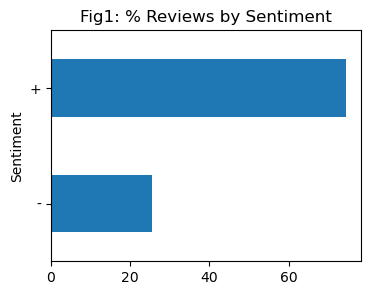

In [5]:
_ = round(df_sen.Sentiment.value_counts()/df_sen.shape[0]*100,2).sort_index()
_.plot(kind = "barh", title = "Fig1: % Reviews by Sentiment", figsize = (4,3));
plt.yticks(ticks=[0,1], labels=['-', '+']);

In [6]:
##creating the training and test sets 
# df_sen = pd.read_pickle("df_sentimen.pkl")
X_train, X_test, y_train, y_test = train_test_split(df_sen.Reviews, df_sen.Sentiment, stratify = df_sen.Sentiment)
print(f" The training set has {X_train.shape[0]} records and the test set has {X_test.shape[0]}")
# X_train.sample(3)
# y_train.value_counts()/y_train.shape[0]

 The training set has 286505 records and the test set has 95502


#####
#### <a name="gs_vec">Gridsearch based Vectorization</a>
Since text data cannot be used directly for predictive modeling, it is first converted into numerical form via vectorization. Two vectorizers are considered, CountVectorizer, which is a frequency based vectorizer that records the counts of each word, and the TfidfVectorizer where the word counts are normalized such that more frequent words (which do not add much additional meaning) are excluded), thus potentially simplifying the vectorizer.

Hyperparameters for each of these vectorizers are tuned via the gridsearch function below and the performance of each is evaluated using a Multinomale Naive Bayes model as a baseline.

In [7]:
##tokenizing and vectorizing the text in the reviews (base vectorizers)
cvec =  CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b") #excluding numeric/alphanumeric tokens
tfvec = TfidfVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b") 

def grid_search(pipe, params, X_train, y_train):
    gs = GridSearchCV(pipe, param_grid = params, scoring = "f1")
    gs.fit(X_train, y_train)
    return gs
    
##useful links
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html

#####
##### (A) CountVectorizer - assessing performance impact of min_df, max_df, ngram_range and max_feature parameters

In [55]:
start_time = time.time()
pipe = Pipeline([('v', cvec),('mnb', MultinomialNB())])
params = {"v__min_df": [5, 10, 25, 50], #higher threshold does add much value in prior tests
          "v__max_df":[.5, .75, .9], #lower thresholds dont add much value in prior tests
          # "v__max_features": [1000, 10000, 50000], #better results using all features
          "v__ngram_range": [(1,1), (1,2)]} 
nbcv = grid_search(pipe, params, X_train, y_train) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #7mins

# gs.cv_results_.keys()
nbcv_results = pd.DataFrame(nbcv.cv_results_).sort_values("rank_test_score").reset_index()
# nbcv_results.to_csv('nbcv_gridsearch_results.csv')
nbcv_results[["param_v__max_df", "param_v__min_df", "param_v__ngram_range", 
                 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_v__max_df,param_v__min_df,param_v__ngram_range,mean_test_score,std_test_score,rank_test_score
0,0.5,5,"(1, 2)",0.960595,0.000288,1
1,0.75,5,"(1, 2)",0.960595,0.000288,1
2,0.9,5,"(1, 2)",0.960595,0.000288,1
3,0.75,10,"(1, 2)",0.956157,0.000268,4
4,0.9,10,"(1, 2)",0.956157,0.000268,4
5,0.5,10,"(1, 2)",0.956157,0.000268,4
6,0.5,25,"(1, 2)",0.950777,0.000491,7
7,0.75,25,"(1, 2)",0.950777,0.000491,7
8,0.9,25,"(1, 2)",0.950777,0.000491,7
9,0.9,50,"(1, 2)",0.947591,0.000520,10


In [56]:
print(f"The model has {len(nbcv.best_estimator_['v'].get_feature_names_out())} parameters")
print(f"AUC score on test set: {roc_auc_score(nbcv.best_estimator_.predict(X_test), y_test).round(2)}")
print(f"F1 score on test set: {f1_score(nbcv.best_estimator_.predict(X_test), y_test).round(2)}")

The model has 192677 parameters
AUC score on test set: 0.93
F1 score on test set: 0.96


<b>Key observations:</b>
- Bigrams appear to perform better than unigrams
- min_df 5 and max_df at 0.75 should be fine
- Final number of features is very large, which in practical terms may be overkill; assessing the impact of dropping the number of features below
####

In [60]:
##to assess the impact of reducing the number of features - running this together with the first girdsearch was taking too long on my local machine
cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 5, max_df = 0.75, ngram_range = (1,2)) 
params = {"v__max_features": [100, 500, 1000, 5000, 10000, 50000, 100000]} 

start_time = time.time()
pipe = Pipeline([('v', cvec),('mnb', MultinomialNB())])
nbcv2 = grid_search(pipe, params, X_train, y_train) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #5mins
nbcv_results2 = pd.DataFrame(nbcv2.cv_results_).sort_values("rank_test_score").reset_index()
# nbcv_results2.to_csv('nbcv_gridsearch_results_features.csv')
nbcv_results2[["param_v__max_features", 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 6.42


,param_v__max_features,mean_test_score,std_test_score,rank_test_score
0,100000,0.958510,0.000239,1
1,50000,0.954928,0.000466,2
2,10000,0.947321,0.000500,3
3,5000,0.944113,0.000616,4
4,1000,0.935139,0.000472,5
5,500,0.927889,0.000780,6
6,100,0.899345,0.000956,7


#####
##### (B) TfidfVectorizer - assessing performance impact of min_df, max_df, ngram_range and max_feature parameters

In [62]:
start_time = time.time()
pipe = Pipeline([('v', tfvec),('mnb', MultinomialNB())])
params = {"v__min_df": [5, 10, 25, 50], #higher threshold does add much value in prior tests
          "v__max_df":[.5, .75, .9], #lower thresholds dont add much value in prior tests
          # "v__max_features": [1000, 10000, 50000], #better results using all features
          "v__ngram_range": [(1,1), (1,2)]} 
nbtf = grid_search(pipe, params, X_train, y_train)
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #14mins

nbtf_results = pd.DataFrame(nbtf.cv_results_).sort_values("rank_test_score").reset_index()
# nbtf_results.to_csv('nbtf_gridsearch_results.csv')
nbtf_results[["param_v__max_df", "param_v__min_df", "param_v__ngram_range", 
                 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 13.95


,param_v__max_df,param_v__min_df,param_v__ngram_range,mean_test_score,std_test_score,rank_test_score
0,0.5,5,"(1, 2)",0.959686,0.000624,1
1,0.75,5,"(1, 2)",0.959686,0.000624,1
2,0.9,5,"(1, 2)",0.959686,0.000624,1
3,0.75,10,"(1, 2)",0.957625,0.000384,4
4,0.9,10,"(1, 2)",0.957625,0.000384,4
5,0.5,10,"(1, 2)",0.957625,0.000384,4
6,0.5,25,"(1, 2)",0.952916,0.000478,7
7,0.75,25,"(1, 2)",0.952916,0.000478,7
8,0.9,25,"(1, 2)",0.952916,0.000478,7
9,0.9,50,"(1, 2)",0.949251,0.000576,10


In [63]:
print(f"The model has {len(nbtf.best_estimator_['v'].get_feature_names_out())} parameters")
print(f"AUC score: {roc_auc_score(nbtf.best_estimator_.predict(X_test), y_test).round(2)}")
print(f"F1 score: {f1_score(nbtf.best_estimator_.predict(X_test), y_test).round(2)}")

The model has 192677 parameters
AUC score: 0.94
F1 score: 0.96


In [64]:
tfvec = TfidfVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 5, max_df = 0.75, ngram_range = (1,2)) 
params = {"v__max_features": [100, 500, 1000, 5000, 10000, 50000, 100000]} 

start_time = time.time()
pipe = Pipeline([('v', tfvec),('mnb', MultinomialNB())])
nbtf2 = grid_search(pipe, params, X_train, y_train) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #6.5mins
nbtf_results2 = pd.DataFrame(nbtf2.cv_results_).sort_values("rank_test_score").reset_index()
# nbtf_results2.to_csv('nbtf_gridsearch_results_features.csv')
nbtf_results2[["param_v__max_features", 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 6.54


,param_v__max_features,mean_test_score,std_test_score,rank_test_score
0,100000,0.959495,0.000557,1
1,50000,0.956296,0.000319,2
2,10000,0.948697,0.000537,3
3,5000,0.945730,0.000637,4
4,1000,0.935212,0.000571,5
5,500,0.926916,0.000768,6
6,100,0.897100,0.001026,7


<b>Gridsearch Results:</b> Based on the analysis above, we choose a vectorizer with the following parameters: 
- min_df = 5 (must appear in atleast 5 documents)
- max_df = 0.75 (must not appear is more than 0.75 documents
- max_features = 10000
- bigrams

Further, both the Countvectorizer and the Tfidf vectorizer perform nearly the same. To speed up processing, for other classification models, we use CountVectorizer with the parameters determined above and a max of 10Kfeatures
#### 

#####
#### <a name="mnb">Multinomial Naive Baiyes</a>

In [11]:
##final vectorizer
cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 50, max_df = 0.75, max_features = 10000, ngram_range = (1,2))
X_train_cv = cvec.fit_transform(X_train)


##Addressing Data Imbalance
##https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
##https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
print(y_train.shape) #(286505,)
print(round(y_train.value_counts()/y_train.shape[0],2)) #1 - 75%, 0-25%

X_train_cv_res, y_train_res = RandomOverSampler().fit_resample(X_train_cv, y_train)
print(y_train_res.value_counts()/y_train_res.shape[0]) #50%each
print(y_train_res.shape)#(427422,)

(286505,)
Sentiment
1    0.75
0    0.25
Name: count, dtype: float64
Sentiment
1    0.5
0    0.5
Name: count, dtype: float64
(427422,)


In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

model = MultinomialNB().fit(X_train_cv_res, y_train_res)
print(f"AUC score on test set: {roc_auc_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") 
print(f"F1 score on test set: {f1_score(model.predict(cvec.transform(X_test)),y_test).round(2)}")

AUC score on test set: 0.86
F1 score on test set: 0.93


#####
#### <a name="lr">Logistic Regression</a>
No significant improvement from regularization

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {"lr__C": [0.1, 0.5, 1.0, 1.5, 2.5, 5, 10]} 
cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 50, max_df = 0.75, max_features = 10000, ngram_range = (1,2))
start_time = time.time()
pipe = Pipeline([('v', cvec),('lr', LogisticRegression(max_iter = 1000))])
lrcv = grid_search(pipe, params, X_train, y_train)
print(f"Runtime: {round((time.time()-start_time)/60, 2)}")

lrcv_results = pd.DataFrame(lrcv.cv_results_).sort_values("rank_test_score")
lrcv_results.to_csv('lrcv_gridsearch_results.csv')
lrcv_results[['params','mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
5,{'lr__C': 5},0.963954,0.000778,1
6,{'lr__C': 10},0.963928,0.000699,2
4,{'lr__C': 2.5},0.963533,0.000819,3
3,{'lr__C': 1.5},0.963190,0.000819,4
2,{'lr__C': 1.0},0.962531,0.000797,5
1,{'lr__C': 0.5},0.961471,0.000936,6
0,{'lr__C': 0.1},0.956786,0.000530,7


In [15]:
model = LogisticRegression(max_iter = 1000).fit(X_train_cv_res, y_train_res)
print(f"AUC score on test set: {roc_auc_score(model.predict(cvec.transform(X_test)),y_test).round(2)}")
print(f"F1 score on test set: {f1_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") 

AUC score on test set: 0.92
F1 score on test set: 0.96


#####
#### <a name="rf">RandomForestClassifier</a>

In [18]:
##https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

model = RandomForestClassifier(max_depth = 10).fit(X_train_cv_res, y_train_res)
print(f"AUC score on test set: {roc_auc_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") #.88
print(f"F1 score on test set: {f1_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") #.94

AUC score on test set: 0.83
F1 score on test set: 0.92


##### 
#### <a name="tb">TextBlob</a>

In [36]:
# https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

In [37]:
#TextBlob
#since this is a pretrained package, no additional training is needed. We use the polarity returned by the TextBlob model where
#any polarities <0 are considered negative and others are considered positive
#https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

textblob_sent_pred = X_test.apply(lambda x: TextBlob(x).sentiment.polarity)
textblob_sent_pred = np.where(textblob_sent_pred >= 0, 1, 0)
print(f"AUC score: {roc_auc_score(textblob_sent_pred, y_test).round(2)}")
print(f"F1 score: {f1_score(textblob_sent_pred, y_test).round(2)}")

AUC score: 0.83
F1 score: 0.89


##### 
#### <a name="vader">VADER</a>

In [39]:
#VADER
#since this is a pretrained package (on social media data), no additional training is needed. We use the compound score returned by the VADER model 
#where any polarities <0 are considered negative and others are considered positive
# https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#code-examples

analyzer = SentimentIntensityAnalyzer()
vader_sent_pred = X_test.apply(lambda x: analyzer.polarity_scores(x)["compound"])
vader_sent_pred = np.where(vader_sent_pred >= 0, 1, 0)
print(f"AUC score: {roc_auc_score(vader_sent_pred, y_test).round(2)}")
print(f"F1 score: {f1_score(vader_sent_pred, y_test).round(2)}")

AUC score: 0.85
F1 score: 0.91


#####
##### <a name="summ">Summary of Results</a>

In [21]:
res_sum = pd.DataFrame({"AUC score" : [0.86, 0.92, 0.83, 0.83, 0.85],
              "F1 score" : [0.93, 0.96, 0.92, 0.89, 0.91]}, 
             index = ["Multi-Nomial Bayes", "Logistic Regression", "RandomForest", "TextBlob", "VADER"],)
res_sum

,AUC score,F1 score
Multi-Nomial Bayes,0.86,0.93
Logistic Regression,0.92,0.96
RandomForest,0.83,0.92
TextBlob,0.83,0.89
VADER,0.85,0.91


###
#### <a name="top">Goal 2: Topic Modeling </a>
<b>What is topic modeling?</b> Topic modeling aims to create coherent groupings of words to glean common themes ("topics") from the text corpus. For this part of the project, we narrow the scope to negative reviews for a subset of the products (in particular, Apple iphones) to assess if we can determine any themes or common topics emerging. This type of information is often used in product improvement

Two techniques are explored for topic extraction - Non Negatice Matrix Factorization and Latent Dirichlett Allocation

In [6]:
####
##### Creating the dataset for topic modeling
# For this project topic modeling focus on negative reviews only and is limited to one product (Apple iphone series 3 through 6). 
# By narrowing the scope, we aim to try to extract main themes of complains/concerns mentioned in the reviews

df_top = df_full[(df_full["Rating"].isin([1, 2])) & (df_full["Brand Name"] == "Apple")][["Brand Name", "Product Name", "Rating", "Reviews"]]
df_top["Product"] =  df_top["Product Name"].apply(lambda x: np.where(
    "phone 3" in x.lower(), "Series3", np.where(
        "phone 4" in x.lower(), "Series4", np.where(
            "phone 5" in x.lower(), "Series5", np.where(
                "phone 6" in x.lower(), "Series6", np.where(
                    "phone 7" in x.lower(), "Series7",""))))))
df_top = df_top[df_top.Product != ""]
print(df_top.shape)
df_top.sample(2)

(12758, 5)


,Brand Name,Product Name,Rating,Reviews,Product
11457,Apple,Apple iPhone 4S 16GB (Black) - Verizon,1,This is NOT a Verizon phone. Totally misrepres...,Series4
51439,Apple,Apple iPhone 6 128GB Factory Unlocked GSM 4G L...,1,This iPhone doesnt Work at all. Battery dies i...,Series6


In [7]:
df_top.Product.value_counts()

Product
Series5    7503
Series6    2444
Series4    2025
Series3     593
Series7     193
Name: count, dtype: int64

In [36]:
# my_stop_words = list(text.ENGLISH_STOP_WORDS)
# ## removing carrier related words because the focus is on phone feedback not carrier
# my_stop_words.extend(['iphone', 'apple', 'verizon', 'att', 'tmobile' 'mobile', 'phone','amazon', 'sprint', 'sim', 'card', 'lock', 'unlock', 
#                       'new', 'refurbish', 'use', 'steal', 'return', 'refund', 'seller', 'sell', 'buy', 'bought', 'carrier',
#                      'fake', 'receive', 'android', 'samsung', 'google', 'money', 'activate', 'unlocked', 'locked', 'purchase'])
# #removing punctuation
# my_stop_words.extend(list(punctuation))

# def spacy_lemma(x):
#     doc = nlp(x)
#     return " ".join([word.lemma_.lower() for word in doc if word.lemma_.lower() not in my_stop_words])

# df_top["Lem_Reviews"] = df_top.Reviews.apply(lambda x: spacy_lemma(x))

In [37]:
#adapted from here:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_topics, n_top_words, title):
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

In [56]:
my_stop_words = list(text.ENGLISH_STOP_WORDS)
## removing carrier related words because the focus is on phone feedback not carrier
my_stop_words.extend(['iphone', 'apple', 'verizon', 'att', 'tmobile' 'mobile', 'phone','amazon', 'sprint', 'sim', 'card', 'locked', 'unlocked', 
                      'unlock', 'lock', 'new', 'refurbished', 'used', 'stolen', 'returned', 'return', 'refund', 'seller', 'sold', 'sell', 'buy', 
                      'bought', 'carrier', 'fake', 'received', 'android', 'samsung', 'google', 'money', 'activated', 'purchased', 'activate',
                      'box'])
cvec = CountVectorizer(stop_words = my_stop_words, lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 25, max_df = 0.75, ngram_range = (1,2))

##### All iPhone Data

2118


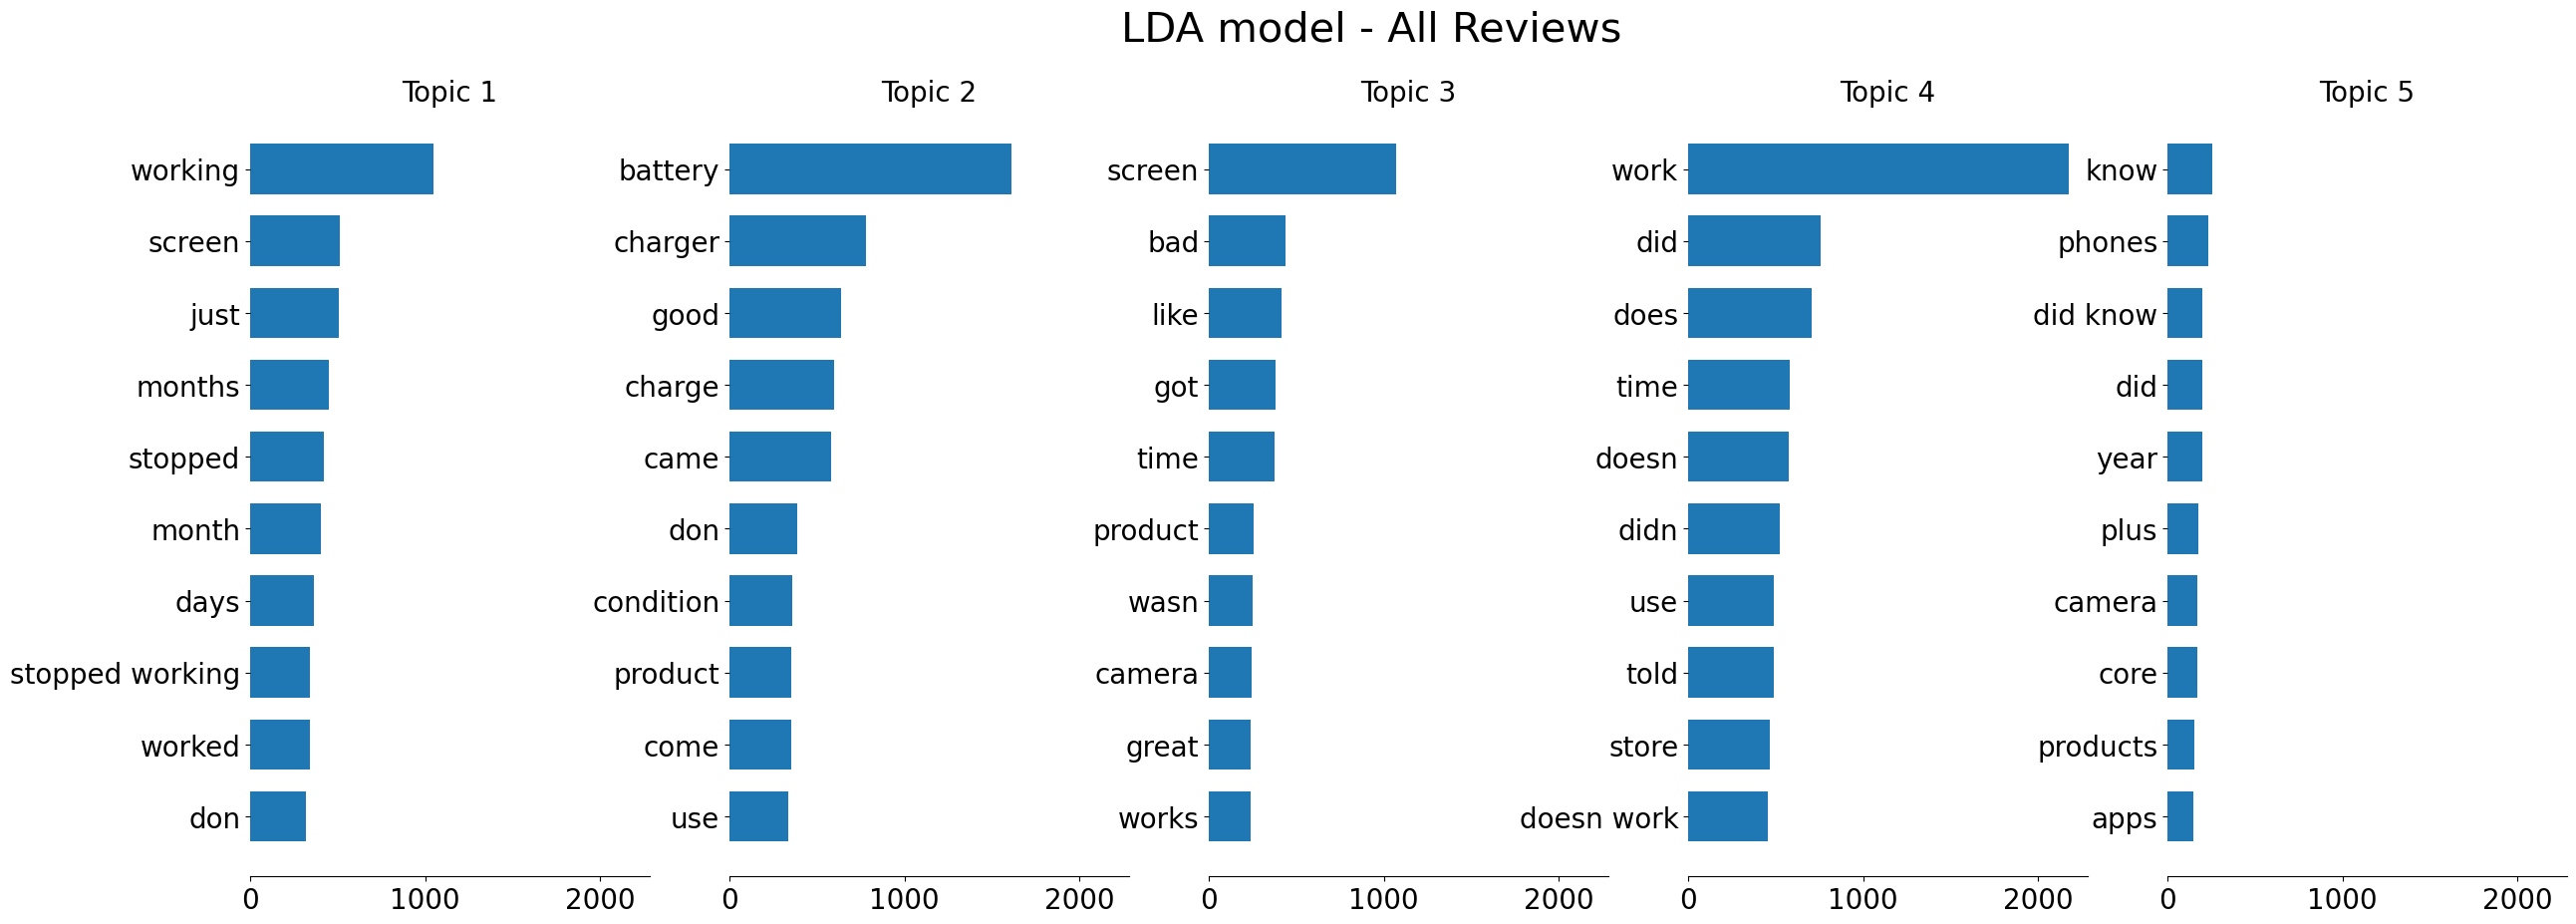

In [60]:
reviews_vec_all = cvec.fit_transform(df_top["Reviews"])
# print(len(cvec.get_feature_names_out())) #2118

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda = LatentDirichletAllocation(n_components = 5, random_state = 0).fit(reviews_vec_all)
plot_top_words(lda, cvec.get_feature_names_out(), 5, 10, "LDA model - All Reviews")

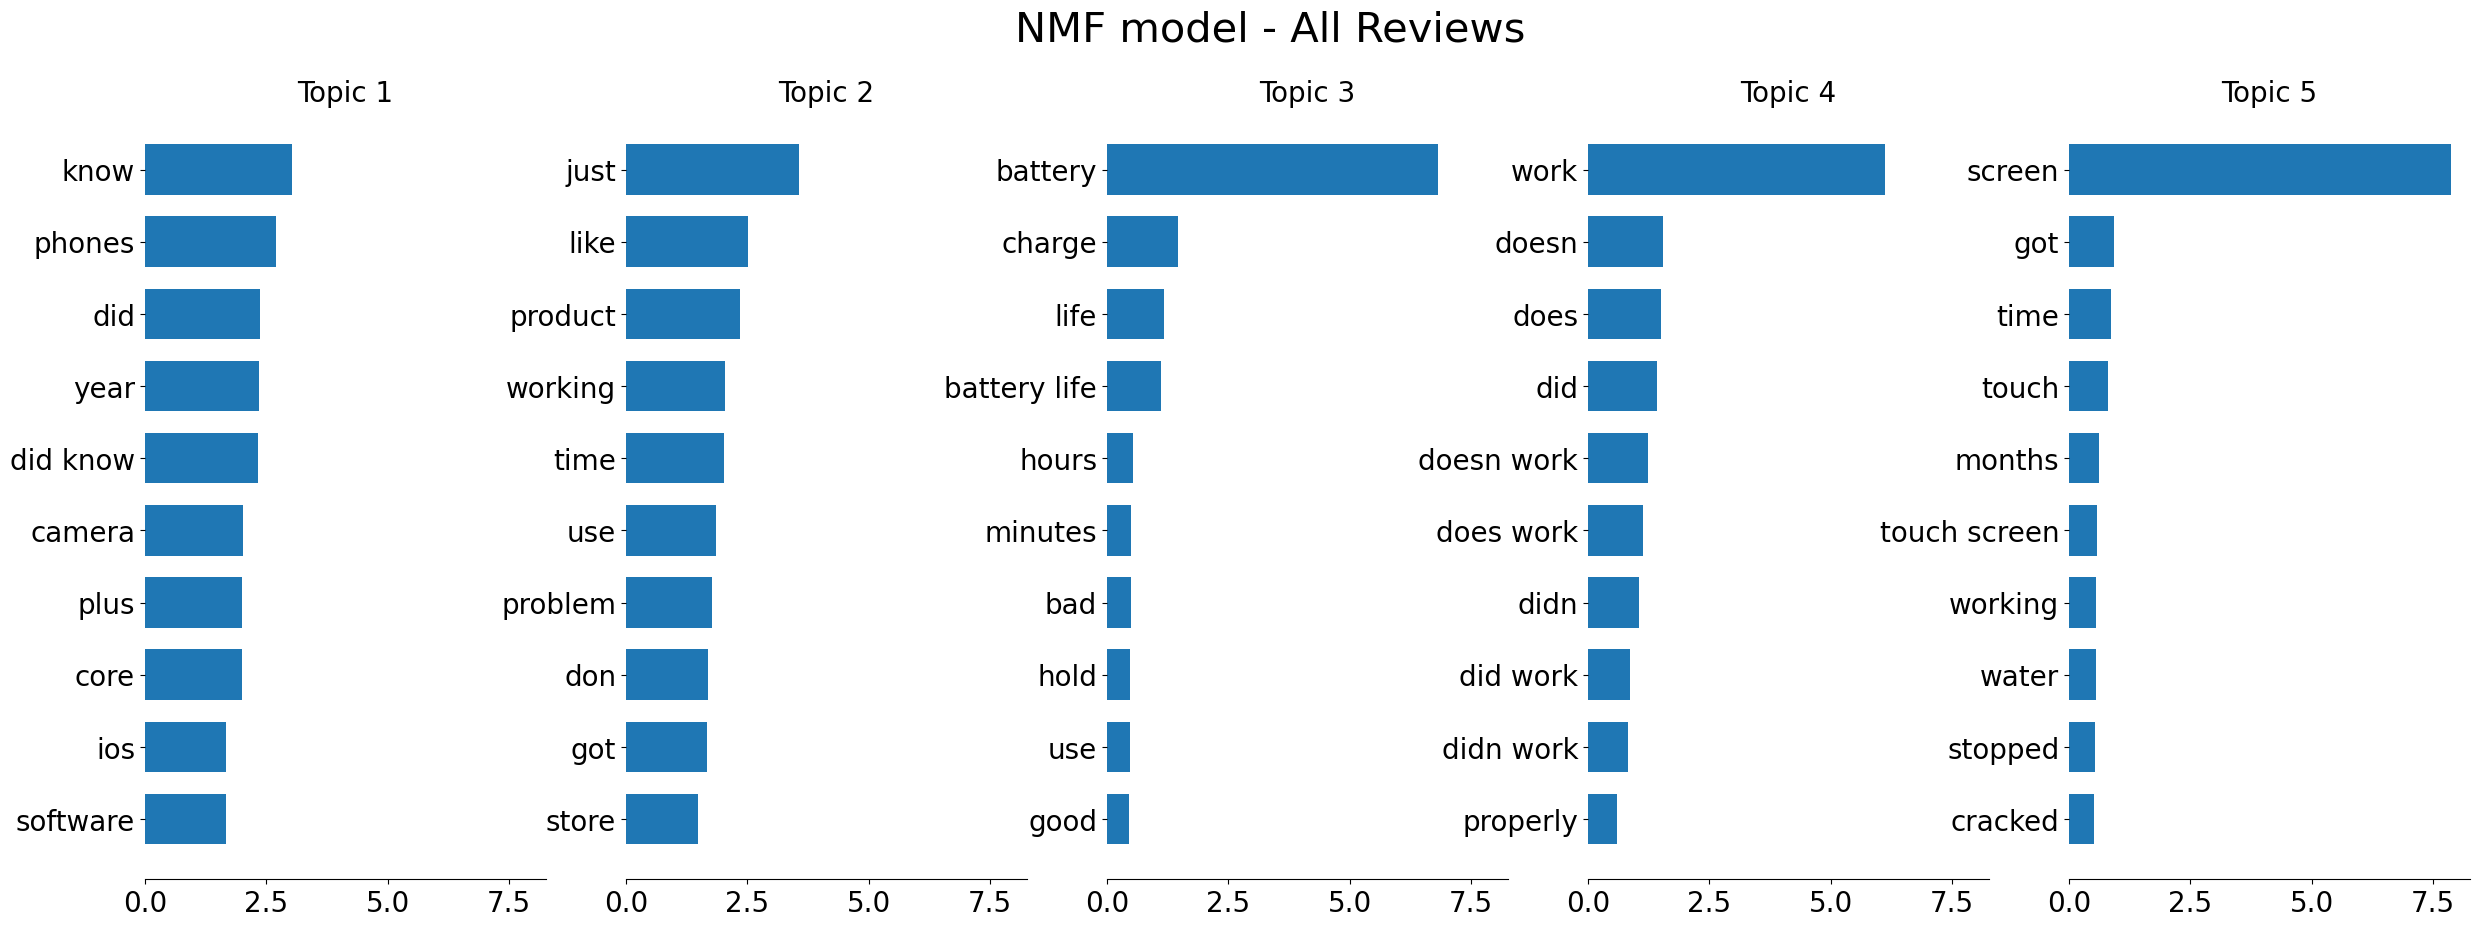

In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf = NMF(n_components = 5).fit(reviews_vec_all)
plot_top_words(nmf, cvec.get_feature_names_out(), 5, 10, "NMF model - All Reviews")

##### Feedback from Series 5 iPhone Reviews Only

In [62]:
df_top_5 = df_top[df_top.Product == "Series5"]
reviews_vec5 = cvec.fit_transform(df_top_5["Reviews"])
print(len(cvec.get_feature_names_out())) #

755


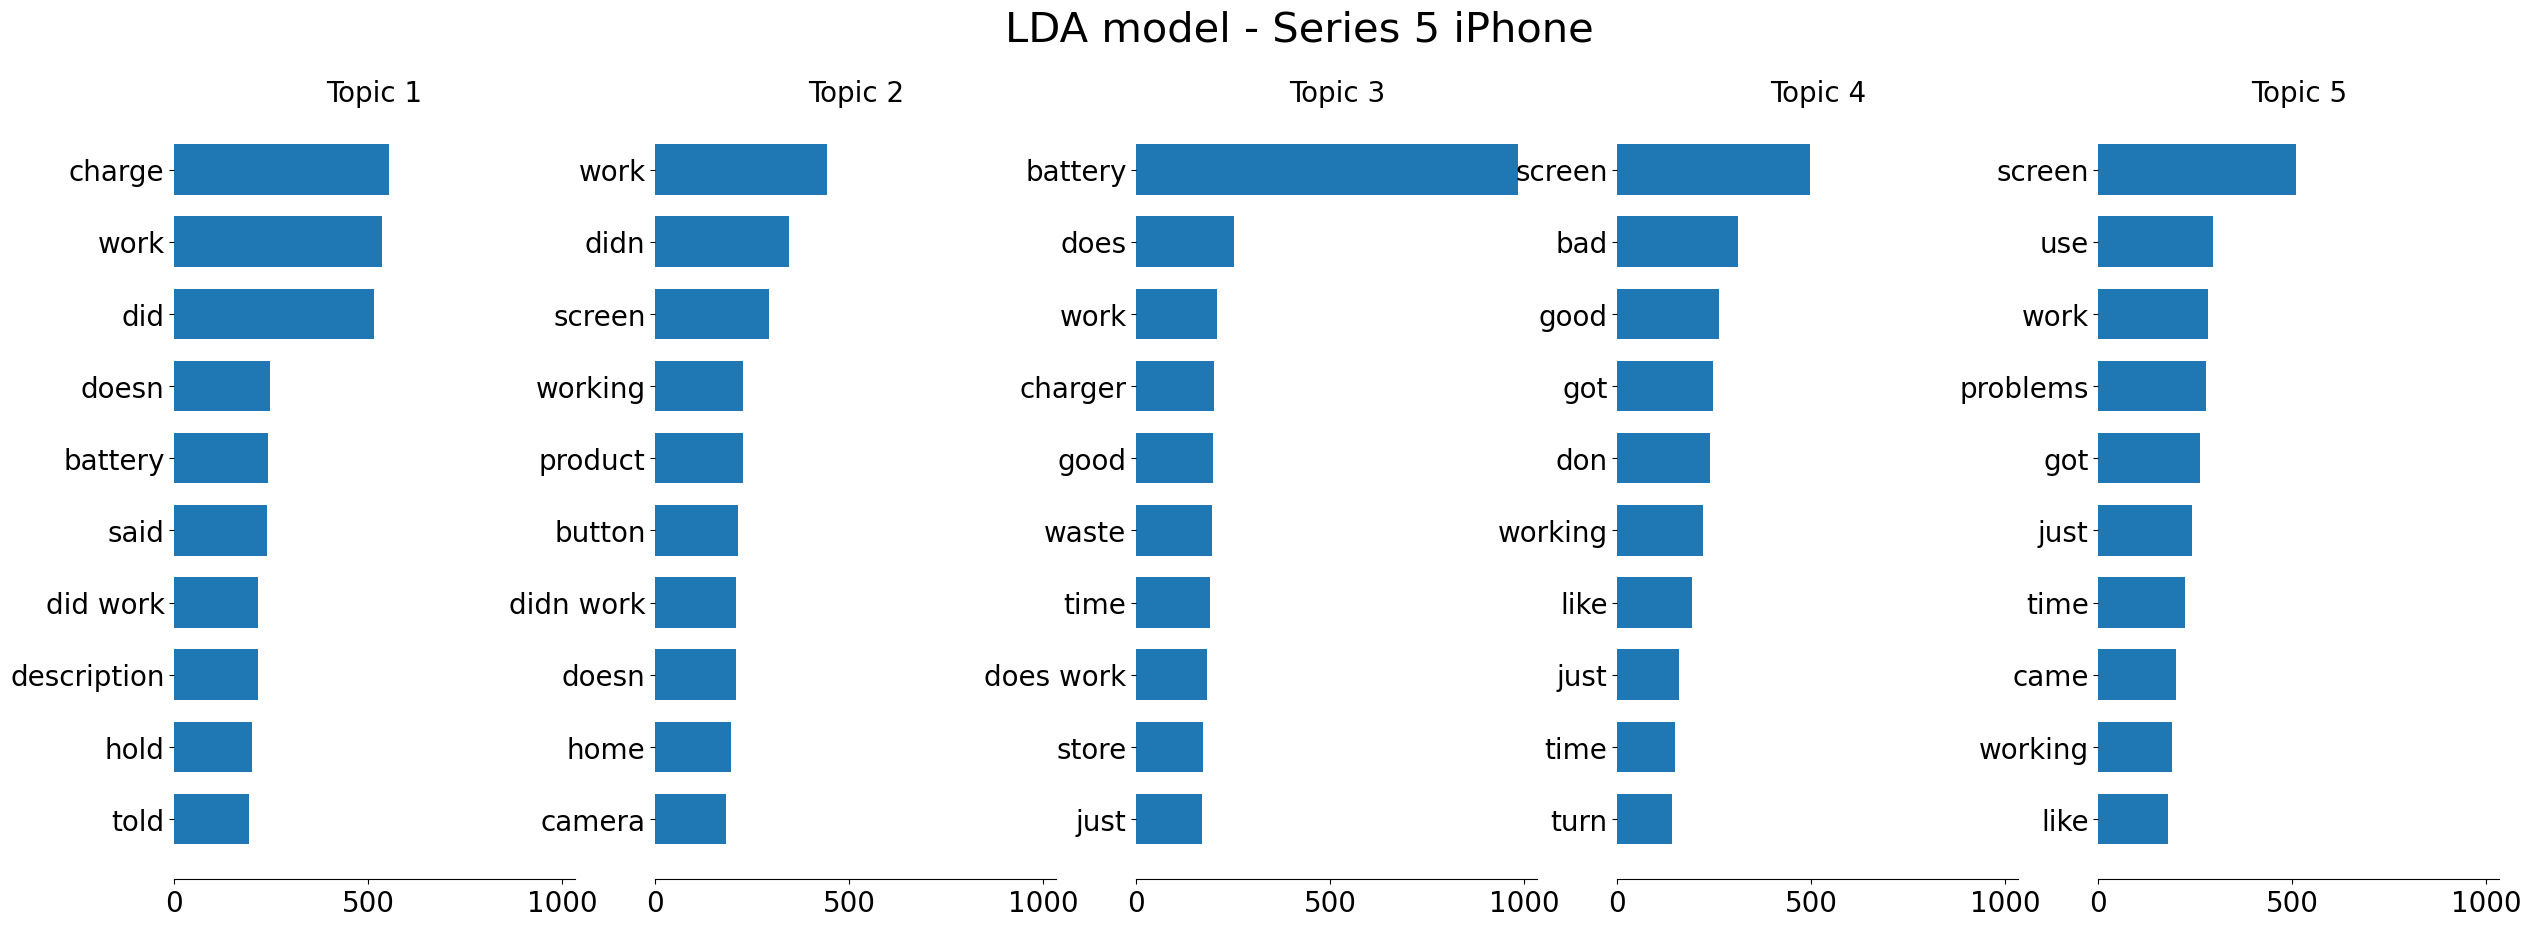

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda = LatentDirichletAllocation(n_components = 5, random_state = 0).fit(reviews_vec5)
plot_top_words(lda, cvec.get_feature_names_out(), 5, 10, "LDA model - Series 5 iPhone")

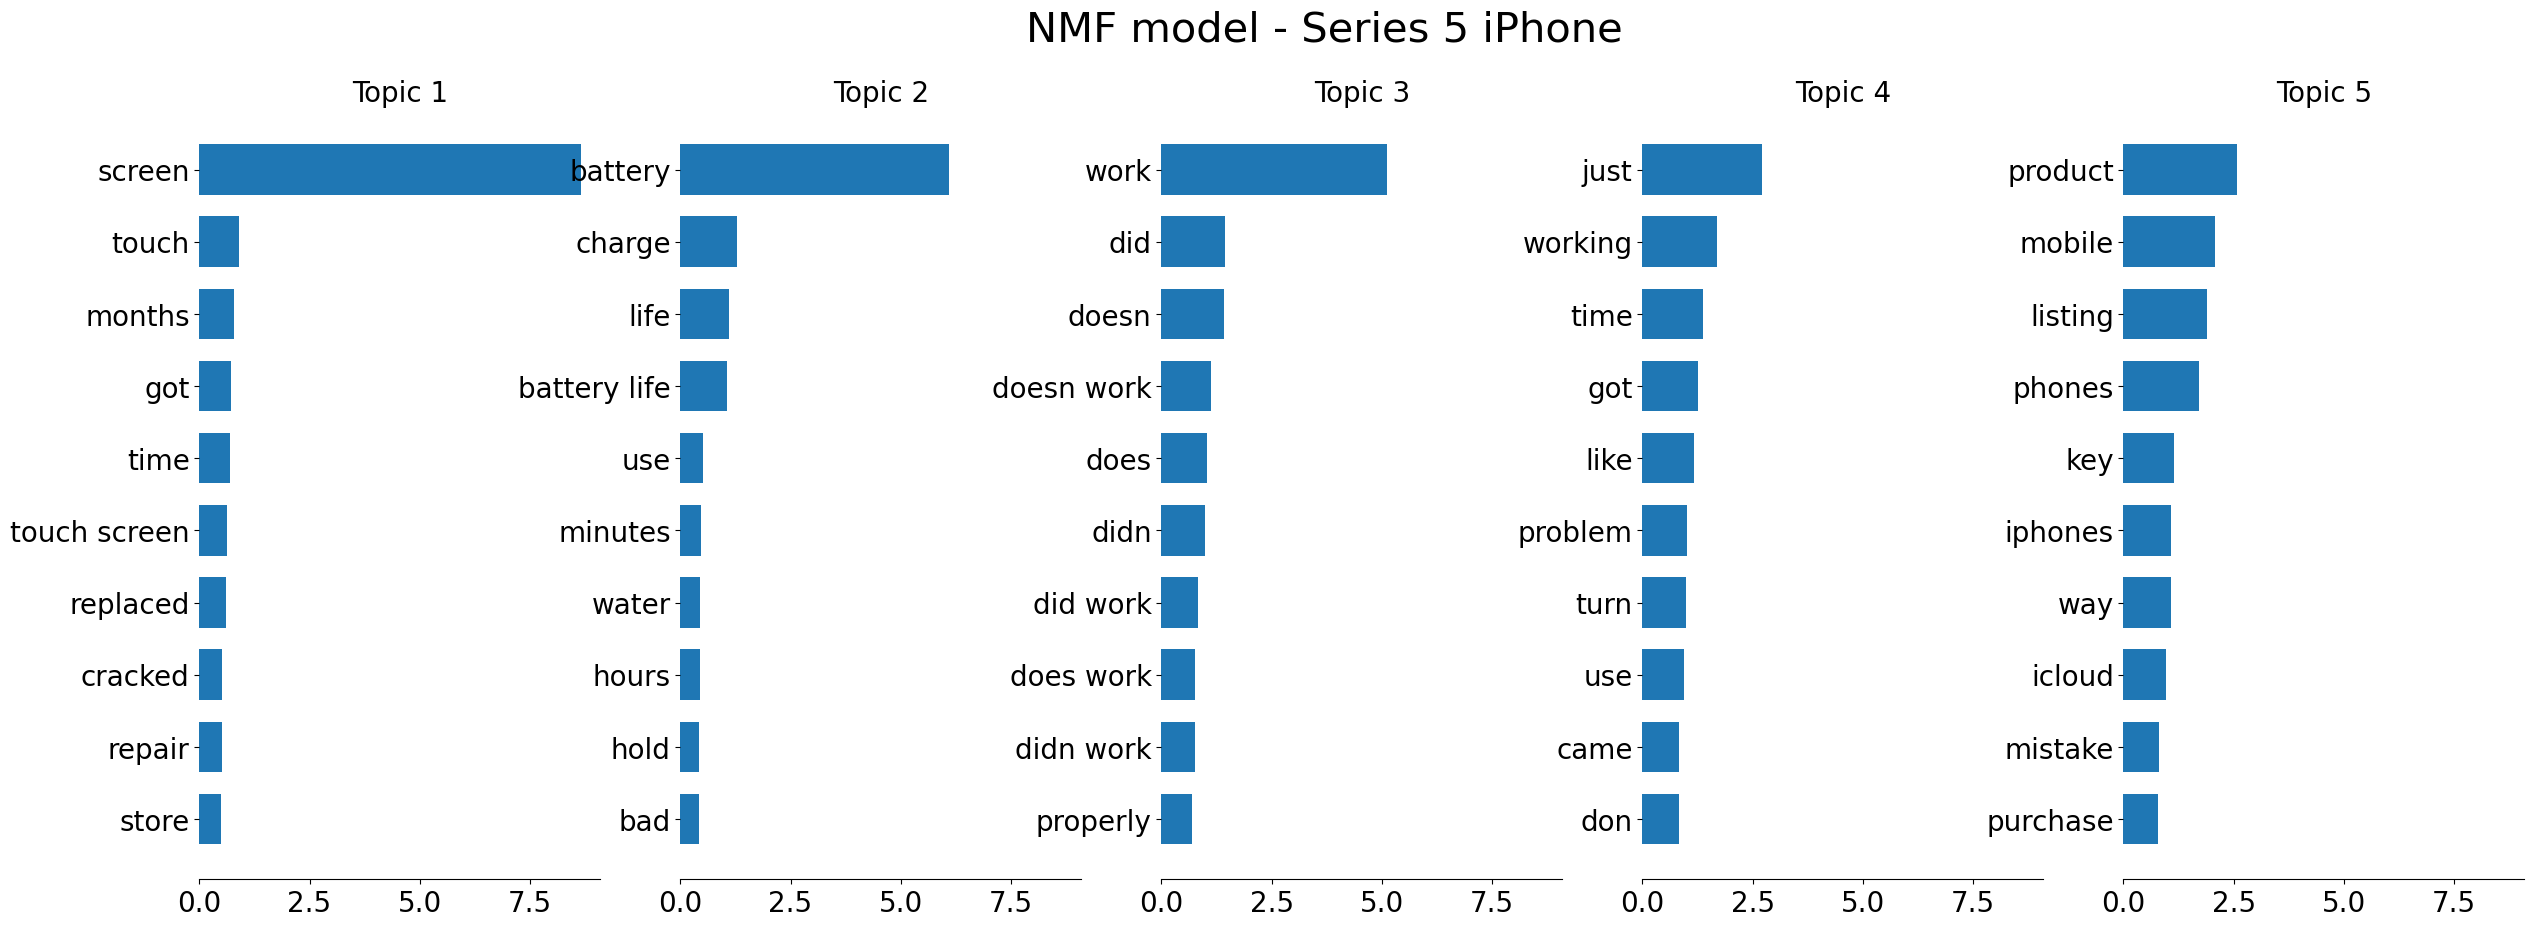

In [64]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf = NMF(n_components = 5).fit(reviews_vec5)
plot_top_words(nmf, cvec.get_feature_names_out(), 5, 10, "NMF model - Series 5 iPhone")

In [66]:
##### Series 4 Topic Modeling

# df_top_4 = df_top[df_top.Product == "Series4"]
# reviews_vec4 =  cvec.fit_transform(df_top_4["Reviews"])
# print(len(cvec.get_feature_names_out())) #

In [65]:
# lda = LatentDirichletAllocation(n_components = 5, random_state = 0).fit(reviews_vec4)
# plot_top_words(lda, cvec.get_feature_names_out(), 10, "LDA model - Series 4 iPhone")

In [67]:
# nmf = NMF(n_components = 5).fit(reviews_vec4)
# plot_top_words(nmf, cvec.get_feature_names_out(), 10, "NMF model - Series 4 iPhone")

In [68]:
##### Series 6 Topic Modeling

# df_top_6 = df_top[df_top.Product == "Series6"]
# reviews_vec6 =  cvec.fit_transform(df_top_6["Reviews"])
# print(len(cvec.get_feature_names_out())) #

In [69]:
# lda = LatentDirichletAllocation(n_components = 5, random_state = 0).fit(reviews_vec6)
# plot_top_words(lda, cvec.get_feature_names_out(), 10, "LDA model - Series 6 iPhone")

In [70]:
# nmf = NMF(n_components = 5).fit(reviews_vec6)
# plot_top_words(nmf, cvec.get_feature_names_out(), 10, "NMF model - Series 6 iPhone")